# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [6]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [(1+i*0.1)*1e4 for i in range(-3,3)]+[(2+0.1*i)*1e4 for i in range(-3,3)]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for rg_str in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=rg_str,
                      num_iters=3000, verbose=True)
        pred_train = svm.predict(X_train_feats)
        pred_test = svm.predict(X_val_feats)
        train_acc = np.mean(pred_train==y_train)
        test_acc = np.mean(y_val == pred_test)
        if test_acc > best_val:
            best_val = test_acc
            best_svm = svm
        results[(lr,rg_str)] = train_acc,test_acc
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 3000: loss 14.137843
iteration 100 / 3000: loss 14.117841
iteration 200 / 3000: loss 14.122055
iteration 300 / 3000: loss 14.120768
iteration 400 / 3000: loss 14.123597
iteration 500 / 3000: loss 14.097636
iteration 600 / 3000: loss 14.088536
iteration 700 / 3000: loss 14.077801
iteration 800 / 3000: loss 14.075793
iteration 900 / 3000: loss 14.062976
iteration 1000 / 3000: loss 14.059137
iteration 1100 / 3000: loss 14.047254
iteration 1200 / 3000: loss 14.053383
iteration 1300 / 3000: loss 14.039014
iteration 1400 / 3000: loss 14.035267
iteration 1500 / 3000: loss 14.020888
iteration 1600 / 3000: loss 14.011586
iteration 1700 / 3000: loss 14.026838
iteration 1800 / 3000: loss 14.008021
iteration 1900 / 3000: loss 13.995984
iteration 2000 / 3000: loss 13.998821
iteration 2100 / 3000: loss 13.983510
iteration 2200 / 3000: loss 13.968792
iteration 2300 / 3000: loss 13.970649
iteration 2400 / 3000: loss 13.977037
iteration 2500 / 3000: loss 13.966797
iteration 2600 / 3000: l

iteration 1000 / 3000: loss 21.638012
iteration 1100 / 3000: loss 21.602636
iteration 1200 / 3000: loss 21.553852
iteration 1300 / 3000: loss 21.515639
iteration 1400 / 3000: loss 21.462887
iteration 1500 / 3000: loss 21.428013
iteration 1600 / 3000: loss 21.375442
iteration 1700 / 3000: loss 21.331231
iteration 1800 / 3000: loss 21.285133
iteration 1900 / 3000: loss 21.240039
iteration 2000 / 3000: loss 21.194835
iteration 2100 / 3000: loss 21.157276
iteration 2200 / 3000: loss 21.119392
iteration 2300 / 3000: loss 21.069977
iteration 2400 / 3000: loss 21.027217
iteration 2500 / 3000: loss 20.965172
iteration 2600 / 3000: loss 20.956262
iteration 2700 / 3000: loss 20.902045
iteration 2800 / 3000: loss 20.863807
iteration 2900 / 3000: loss 20.803344
iteration 0 / 3000: loss 23.299620
iteration 100 / 3000: loss 23.238575
iteration 200 / 3000: loss 23.181170
iteration 300 / 3000: loss 23.133489
iteration 400 / 3000: loss 23.060808
iteration 500 / 3000: loss 23.025425
iteration 600 / 3000

iteration 2100 / 3000: loss 14.024467
iteration 2200 / 3000: loss 13.940712
iteration 2300 / 3000: loss 13.856744
iteration 2400 / 3000: loss 13.771151
iteration 2500 / 3000: loss 13.677800
iteration 2600 / 3000: loss 13.602639
iteration 2700 / 3000: loss 13.509677
iteration 2800 / 3000: loss 13.440884
iteration 2900 / 3000: loss 13.345502
iteration 0 / 3000: loss 16.808755
iteration 100 / 3000: loss 16.649913
iteration 200 / 3000: loss 16.504563
iteration 300 / 3000: loss 16.356091
iteration 400 / 3000: loss 16.217450
iteration 500 / 3000: loss 16.059810
iteration 600 / 3000: loss 15.934482
iteration 700 / 3000: loss 15.788531
iteration 800 / 3000: loss 15.653588
iteration 900 / 3000: loss 15.523987
iteration 1000 / 3000: loss 15.404090
iteration 1100 / 3000: loss 15.271138
iteration 1200 / 3000: loss 15.146677
iteration 1300 / 3000: loss 15.014388
iteration 1400 / 3000: loss 14.888416
iteration 1500 / 3000: loss 14.792828
iteration 1600 / 3000: loss 14.661369
iteration 1700 / 3000: l

iteration 0 / 3000: loss 25.167930
iteration 100 / 3000: loss 24.521126
iteration 200 / 3000: loss 23.883904
iteration 300 / 3000: loss 23.277442
iteration 400 / 3000: loss 22.696708
iteration 500 / 3000: loss 22.125119
iteration 600 / 3000: loss 21.582428
iteration 700 / 3000: loss 21.065837
iteration 800 / 3000: loss 20.591033
iteration 900 / 3000: loss 20.087504
iteration 1000 / 3000: loss 19.641917
iteration 1100 / 3000: loss 19.202291
iteration 1200 / 3000: loss 18.783356
iteration 1300 / 3000: loss 18.381624
iteration 1400 / 3000: loss 17.993433
iteration 1500 / 3000: loss 17.625845
iteration 1600 / 3000: loss 17.263513
iteration 1700 / 3000: loss 16.919396
iteration 1800 / 3000: loss 16.594094
iteration 1900 / 3000: loss 16.288385
iteration 2000 / 3000: loss 15.987156
iteration 2100 / 3000: loss 15.696778
iteration 2200 / 3000: loss 15.436424
iteration 2300 / 3000: loss 15.170451
iteration 2400 / 3000: loss 14.906621
iteration 2500 / 3000: loss 14.665561
iteration 2600 / 3000: l

iteration 1400 / 3000: loss 9.314993
iteration 1500 / 3000: loss 9.247780
iteration 1600 / 3000: loss 9.193895
iteration 1700 / 3000: loss 9.151791
iteration 1800 / 3000: loss 9.117627
iteration 1900 / 3000: loss 9.092508
iteration 2000 / 3000: loss 9.072487
iteration 2100 / 3000: loss 9.056489
iteration 2200 / 3000: loss 9.043752
iteration 2300 / 3000: loss 9.033635
iteration 2400 / 3000: loss 9.026004
iteration 2500 / 3000: loss 9.020114
iteration 2600 / 3000: loss 9.015646
iteration 2700 / 3000: loss 9.011580
iteration 2800 / 3000: loss 9.008078
iteration 2900 / 3000: loss 9.005462
iteration 0 / 3000: loss 22.022853
iteration 100 / 3000: loss 18.272020
iteration 200 / 3000: loss 15.593950
iteration 300 / 3000: loss 13.695062
iteration 400 / 3000: loss 12.337585
iteration 500 / 3000: loss 11.376793
iteration 600 / 3000: loss 10.693993
iteration 700 / 3000: loss 10.199811
iteration 800 / 3000: loss 9.851437
iteration 900 / 3000: loss 9.608148
iteration 1000 / 3000: loss 9.433158
itera

In [7]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.416


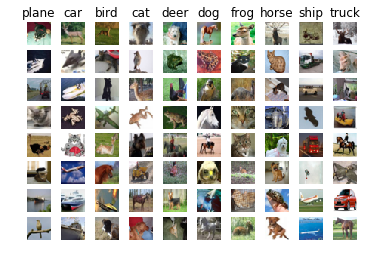

In [8]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [9]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000L, 155L)
(49000L, 154L)


In [16]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# Your code
results = {}
best_val_acc = 0
learning_rates = np.array([1e-2,1e-1,1,3,])
regularization_strengths = [1e-3,5e-3,1e-2,1e-1,0.5,1]
for l_r in learning_rates:
    for r_s in regularization_strengths:
        net = TwoLayerNet(input_dim,hidden_dim,num_classes)
        stats = net.train(X_train_feats,y_train,X_val_feats,y_val,num_iters = 2000,batch_size =200 ,learning_rate=l_r, learning_rate_decay=0.95,
                            reg=r_s, verbose=False)
        val_acc = (net.predict(X_val_feats)==y_val).mean()
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_net = net
        results[(l_r,r_s)] = val_acc
        
for lr, reg in sorted(results):
    val_accuracy = results[(lr, reg)]
    print('lr %e reg %e val accuracy: %f' % (
                lr, reg, val_accuracy))    
print('best validation accuracy achieved during cross-validation: %f' % best_val_acc)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################


lr 1.000000e-02 reg 1.000000e-03 val accuracy: 0.207000
lr 1.000000e-02 reg 5.000000e-03 val accuracy: 0.215000
lr 1.000000e-02 reg 1.000000e-02 val accuracy: 0.233000
lr 1.000000e-02 reg 1.000000e-01 val accuracy: 0.134000
lr 1.000000e-02 reg 5.000000e-01 val accuracy: 0.078000
lr 1.000000e-02 reg 1.000000e+00 val accuracy: 0.078000
lr 1.000000e-01 reg 1.000000e-03 val accuracy: 0.543000
lr 1.000000e-01 reg 5.000000e-03 val accuracy: 0.530000
lr 1.000000e-01 reg 1.000000e-02 val accuracy: 0.510000
lr 1.000000e-01 reg 1.000000e-01 val accuracy: 0.303000
lr 1.000000e-01 reg 5.000000e-01 val accuracy: 0.079000
lr 1.000000e-01 reg 1.000000e+00 val accuracy: 0.098000
lr 1.000000e+00 reg 1.000000e-03 val accuracy: 0.568000
lr 1.000000e+00 reg 5.000000e-03 val accuracy: 0.550000
lr 1.000000e+00 reg 1.000000e-02 val accuracy: 0.491000
lr 1.000000e+00 reg 1.000000e-01 val accuracy: 0.288000
lr 1.000000e+00 reg 5.000000e-01 val accuracy: 0.079000
lr 1.000000e+00 reg 1.000000e+00 val accuracy: 0

In [ ]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)